# Messiaen: La liturgie de Cristal
## Piano and Cello ostinato

In [1]:
from maelzel.core import *
from itertools import cycle
from pitchtools import *
from IPython.display import display, Audio

csoundengine.magic extension loaded
Magics available: %csound, %%csound, %%definstr


In [2]:
cfg = newConfig()
cfg['play.verbose'] = False
cfg['play.pitchInterpolation'] = 'cos'
cfg['play.schedLatency'] = 0.01

### Score Structure

The score does not have any tempo changes, just a slow 3/4

In [3]:
setScoreStruct(ScoreStruct((3, 4), quarterTempo=40))

## Talea / Color

The two *ostinati* (piano and cello) are defined by a seq. of pitches/chords and a sequence of durations, of different size. When combining both these sequences fall out of phase, resulting in multiple rhythmical variations of the pitch structure

The cello durations are defined based on two cells, **A** and **B**. The *talea* (duration sequence) consists of **A** + **B** + **B**<sub>reversed</sub>

In [4]:
lowerChords = [
    "F3 G3 Bb3 C4",
    "F3 G3 Bb3 C4",
    "F3 Ab3 Bb3 Db4",
    "F3 Ab3 Bb3 Db4",
    
    "F3 G3 Bb3 D4",
    "F3 G3 Bb3 D4",
    "F3 A3 C4 D4",
    "F3 A3 C4 D4",
    
    "F3 Bb3 Db4",
    "F3 B3 D4",
    "F3 C4 Eb4",
    "F3 C#4 E4",
    
    "Ab3 Eb4 Gb4",
    "Ab3 Eb4 F4",
    "Gb3 Db4 Ab4",
    "Gb3 Db4 Bb4",
    
    "A3 C4 D4 F#4 Bb4",
    "Bb3 C#4 E4 G#4",
    "C4 D4 F4",
    "C#4 E4 F#4",
    
    "F4 G#4 Bb4",
    "F#4 A4 B4",
    "F4 Bb4",
    "E4 Ab4",
    
    "D4 G4",
    "C#4 F4",
    "B3 E4",
    "Ab3 C#4",
    "Gb3 3B",
]

upperChords = [
    "Eb4 B4 E5",
    "Eb4 A4 D5",
    "Eb4 A4 D5",
    "Eb4 G4 C5",
    "F#4 B4 C5",
    "E4 A4 C5",
    "G4 C#5 F#5",
    "G4 B4 E5",
    "Gb4 E5",
    "G4 E5 G5",
    "Ab4 G5",
    "A4 G5 B5",
    "Bb4 Eb5 Gb5 Cb6",
    "Bb4 Db5 F5 Bb5",
    "Eb5 Ab5 Cb6 Eb6",
    "D5 F5 Bb5 D6",
    "Db5 Gb5 Bb5 Db6",
    "C5 D5 G#5 C6",
    "A4 C#5 E5 A5",
    "Bb4 D5 F5",
    "D5 F#5 A5",
    "D#5 E#5 G#5",
    "D5 E5 G5",
    "C#5 D5",
    "B4 C#5 E5",
    "Bb4 B4 F5",
    "Ab4 Bb4",
    "F4 G4",
    "Eb4 F4",
]

pianoDurs = [1, 1, 1, 0.5, 
             0.75, 0.5, 0.5, 0.5, 
             0.5, 0.75, 0.75, 0.75, 
             0.25, 0.5, 0.75, 1, 
             2]

celloPitches = ["C4", "E4", "D4", "F#4", "Bb3"]
celloA = [2, 1.5, 2]  
celloB = [2, 0.5, 0.5, 1.5, 0.5, 0.5]
celloDurs = celloA + celloB + celloB[::-1]

In [5]:
def makeIsorhythm(cls, color, talea, maxdur):
    totaldur = 0
    for n, dur in zip(cycle(color), cycle(talea)):
        totaldur += dur
        if totaldur > maxdur:
            break
        yield cls(n, dur=dur)

In [6]:
maxdur = 80

# Piano
leftchords = makeIsorhythm(Chord, lowerChords, pianoDurs, maxdur)
rightchords = makeIsorhythm(Chord, upperChords, pianoDurs, maxdur)

# Cello
cellonotes0 = makeIsorhythm(Note, celloPitches, celloDurs, maxdur)

# Add cello glissandi
cellonotes = []
import random
for n in cellonotes0:
    if n.pitch == n2m("4F#"):
        if n.dur <= 0.8:
            cellonotes.append(n.clone(gliss=True))
        else:
            # Uncomment the following line for some variation in the gliss' length
            glissdur = random.uniform(0.2, 0.75)
            # glissdur = 0.5
            n0 = n.clone(dur=n.dur-glissdur, tied=True)
            n1 = n.clone(dur=glissdur, start=n0.end, gliss=True)
            cellonotes.extend([n0, n1])
    else:
        cellonotes.append(n)

In [7]:
# Create voices, add offset
lefthand  = Voice(list(leftchords), 'L').timeShift(2)
righthand = Voice(list(rightchords), 'R').timeShift(2)
cello = Voice(cellonotes, 'cello').timeShift(4.5).transpose(24)

# Score, from high to low
sco = Score([cello, righthand, lefthand])


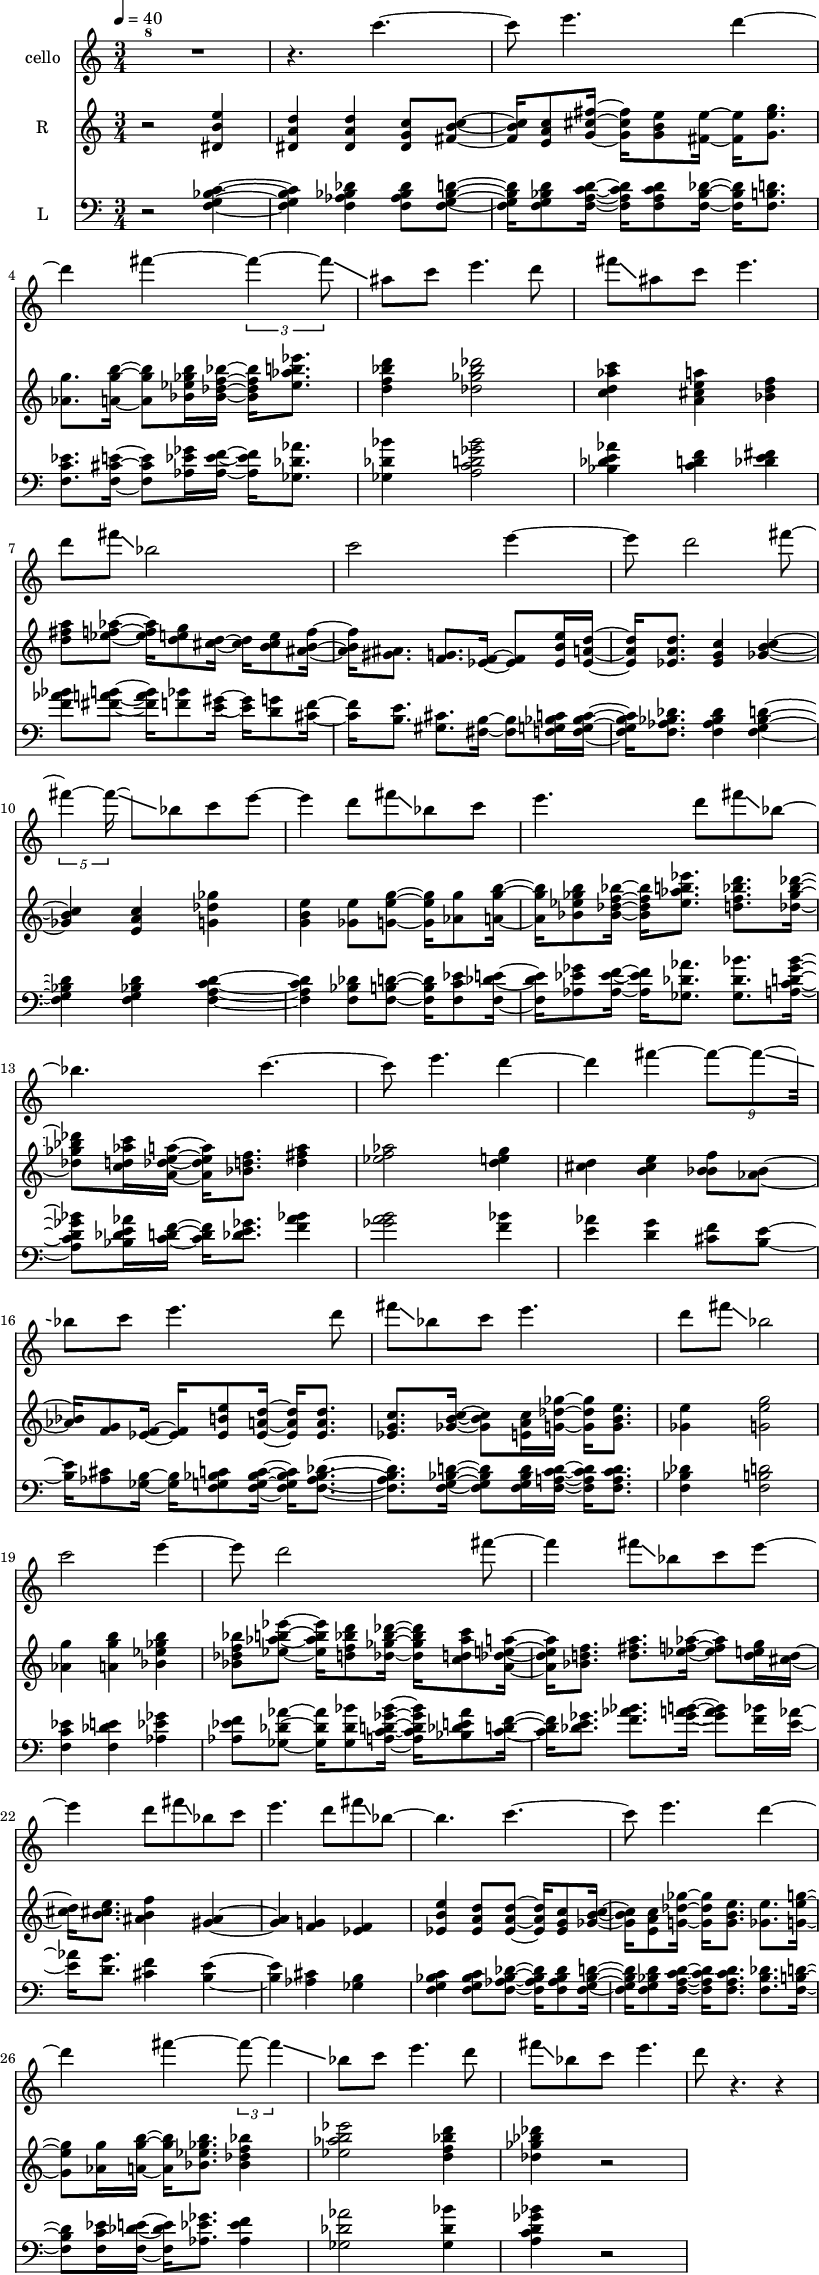

In [8]:
sco

In [9]:
# Define an instrument for cello harmonics
defPreset(
    'flageolet-vibr', 
    audiogen=r'''
    |imaxvibfreq=5.6|
    kt timeinsts
    kvibfreq  = bpf:k(kt, 0, 0, 0.7, imaxvibfreq)
    kvibsteps = bpf:k(kt, 0, 0, 1.1, 0.25)
    kvibr = oscili:k(kvibsteps, kvibfreq) - kvibsteps*0.5
    kpitch = lag:k(kpitch, 1)
    kfreq = mtof:k(kpitch + kvibr)
    aout1 = oscili:a(kamp, a(kfreq))
    aout1 += oscili:a(kamp*0.08, kfreq*2)
    aout1 += oscili:a(kamp*0.01, kfreq*3)
    ''', 
    temporary=True,
)

Preset: flageolet-vibr  
  {imaxvibfreq=5.6}
  audiogen:
    kt timeinsts
    kvibfreq  = bpf:k(kt, 0, 0, 0.7, imaxvibfreq)
    kvibsteps = bpf:k(kt, 0, 0, 1.1, 0.25)
    kvibr = oscili:k(kvibsteps, kvibfreq) - kvibsteps*0.5
    kpitch = lag:k(kpitch, 1)
    kfreq = mtof:k(kpitch + kvibr)
    aout1 = oscili:a(kamp, a(kfreq))
    aout1 += oscili:a(kamp*0.08, kfreq*2)
    aout1 += oscili:a(kamp*0.01, kfreq*3)

In [10]:
# Make the highest note of the piano somewhat louder than the rest
for ch in righthand:
    ch[-1].amp = 1
    for n in ch[:-1]:
        n.amp = 0.6

In [ ]:
# sf2 from http://freepats.zenvoid.org/Piano/YDP-GrandPiano/grand-piano-YDP-20160804.tar.bz2
defPresetSoundfont('piano', '~/soundfonts/grand-piano-ydp.sf2')


In [17]:
# Set playback options

maingain = 0.8
lefthand.setplay(instr='piano', gain=maingain, position=0.25)
righthand.setplay(instr='piano', gain=maingain/2, position=0.25)
cello.setplay(instr='flageolet-vibr', gain=maingain/8, fade=(0.2, 0.1), position=0.75);

In [12]:
sco.play()

Button(description='Stop', style=ButtonStyle())

Output()

p1,start,dur,imaxvibfreq,4:iparams_,5:idataidx_,6:inumbps,7:ibplen,8:igain_,9:ichan_,10:ipos,11:ifade0,12:ifade1,13:ipchintrp_,14:ifadekind_,15,16,17,18,19,20
1001.0002 𝍪,6.003,3.000,5.6,104,15,2,3,0.0625,1,0.75,0.2,0.1,1,1,0,84,1,3,84,1
1001.0003 𝍪,9.003,2.250,5.6,105,15,2,3,0.0625,1,0.75,0.2,0.1,1,1,0,88,1,2.25,88,1
1001.0004 𝍪,11.253,3.000,5.6,106,15,2,3,0.0625,1,0.75,0.2,0.1,1,1,0,86,1,3,86,1
1001.0005 𝍪,14.253,3.750,5.6,107,15,4,3,0.0625,1,0.75,0.2,0.1,1,1,0,90,1,2.4463,90,1
1001.0006 𝍪,18.003,0.750,5.6,108,15,2,3,0.0625,1,0.75,0.2,0.1,1,1,0,84,1,0.75,84,1
1001.0007 𝍪,18.753,2.250,5.6,109,15,2,3,0.0625,1,0.75,0.2,0.1,1,1,0,88,1,2.25,88,1
1001.0008 𝍪,21.003,0.750,5.6,110,15,2,3,0.0625,1,0.75,0.2,0.1,1,1,0,86,1,0.75,86,1
1001.0009 𝍪,21.753,1.500,5.6,111,15,3,3,0.0625,1,0.75,0.2,0.1,1,1,0,90,1,0.75,82,1
1001.001 𝍪,23.253,0.750,5.6,112,15,2,3,0.0625,1,0.75,0.2,0.1,1,1,0,84,1,0.75,84,1
1001.0011 𝍪,24.003,2.250,5.6,113,15,2,3,0.0625,1,0.75,0.2,0.1,1,1,0,88,1,2.25,88,1


## Global Effects

Create a reverb, scheduled at a higher priority

In [12]:
s = play.getPlayEngine().session()
s.defInstr('reverb', r'''
  |kfeedback=0.6|
  amon1, amon2 monitor
  a1, a2 reverbsc amon1, amon2, kfeedback, 12000, sr, 0.5
  outch 1, a1-amon1, 2, a2-amon2
''')

Instr(reverb, kfeedback:5=0.6)

In [14]:
ev = s.sched('reverb', priority=5)
ev.ui(kfeedback=(0, 1))

Button(description='Stop', style=ButtonStyle())

FloatSlider(value=0.6, description='kfeedback', layout=Layout(width='80%'), max=1.0, readout_format='.3f', ste…

## Render Offline

In [18]:
endtime = sco.endAbsTime()
with play.OfflineRenderer("messiaen.wav") as r:
    r.sched('reverb', dur=float(endtime)+3,priority=5)
    sco.play()

In [19]:
# convert to mp3 to be able to upload the notebook
import sndfileio
samples, info = sndfileio.sndget('messiaen.wav')
sndfileio.mp3write('messiaen.mp3', samples, info.samplerate, bitrate=128)

Audio(value=b'\xff\xfb\x90d\x00\x0f\xf0\x00\x00i\x00\x00\x00\x08\x00\x00\r \x00\x00\x01\x00\x00\x01\xa4\x00\x0…

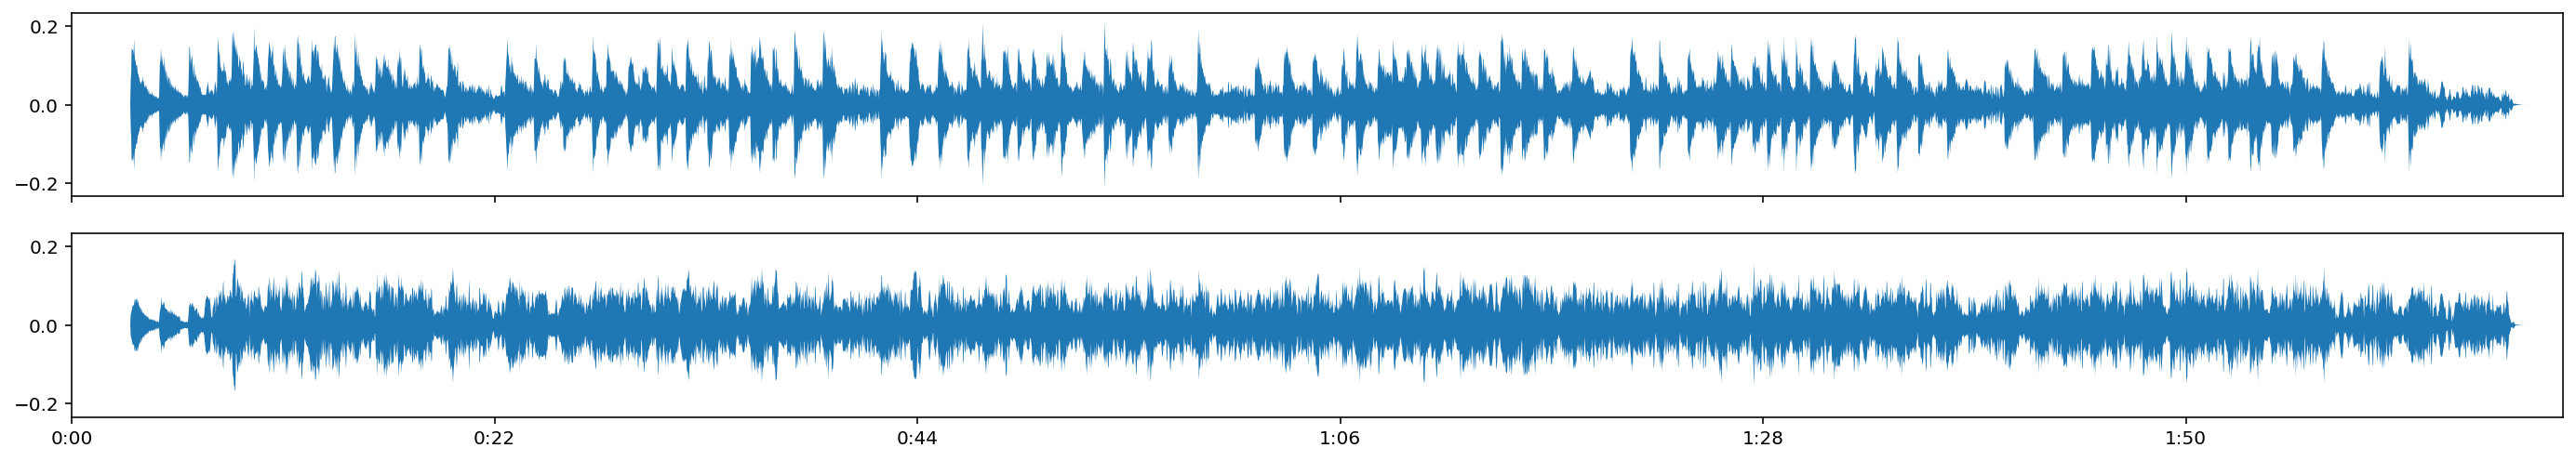

In [20]:
from maelzel.snd import plotting
import ipywidgets

samples, info = sndfileio.sndget('messiaen.mp3')
plotting.plotWaveform(samples, info.samplerate)
ipywidgets.Audio.from_file("messiaen.mp3", autoplay=False, loop=False, layout=ipywidgets.Layout(width='80%'))

In [27]:
Audio(url="https://github.com/gesellkammer/maelzel/raw/master/examples/messiaen.mp3")